In [6]:
data_dir = "./E6/E6_VIA_MD"
import os
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

### Load all simulation complexes

In [7]:
xtc_filename="prot_E6_via_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6_via_complex_VIA_cluster_center.tpr"

E6_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename),os.path.join(data_dir, xtc_filename))


### Calculate all RMSD values and load in a dataframe

  0%|          | 0/50001 [00:00<?, ?it/s]

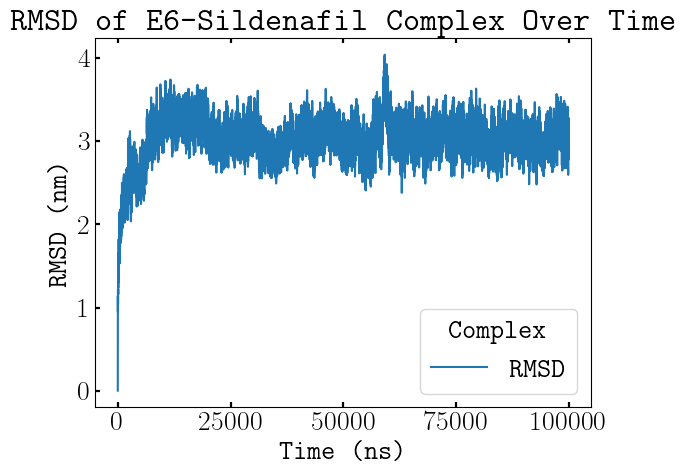

In [9]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex

R_local = rms.RMSD(E6_sildenafil_complex, E6_sildenafil_complex, select='backbone', ref_frame=0)
R_local.run(verbose=True)
times = R_local.results.rmsd[:, 1]
rmsd = R_local.results.rmsd[:, 2]
# Create a DataFrame to hold the RMSD and later RMSF and Rg results
E6_sildenafil_df = pd.DataFrame({'Time': times, 'RMSD': rmsd})


# Prepare and display the plot.
E6_sildenafil_df.set_index('Time', inplace=True)
E6_sildenafil_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of E6-Sildenafil Complex Over Time')
plt.legend(title='Complex')
plt.show()


### Calculate all RMSF and load in a dataframe

In [12]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
c_alphas_c = E6_sildenafil_complex.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=False)
resids = c_alphas_c.resids
rmsf = R_c.results.rmsf
E6_sildenafil_df['RMSF'] = [rmsf] * len(E6_sildenafil_df)
E6_sildenafil_df['Resid'] = [resids] * len(E6_sildenafil_df)


### Calculate all Radii of Gyration and load in a dataframe 

  0%|          | 0/50001 [00:00<?, ?it/s]

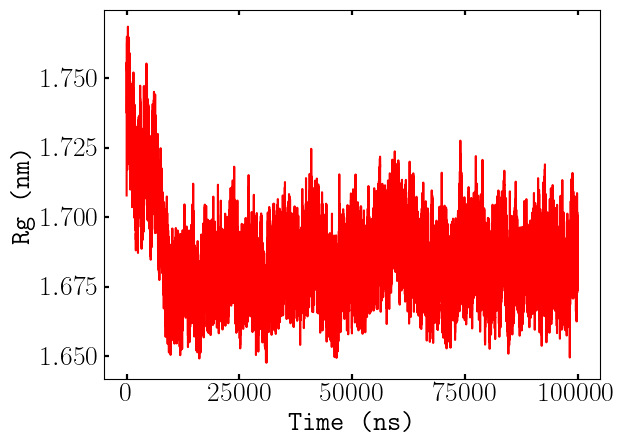

In [16]:
import pandas as pd

group = E6_sildenafil_complex.select_atoms('protein')
times = []
rg = []
for ts in tqdm(E6_sildenafil_complex.trajectory):
    times.append(ts.time)
    rg.append(group.radius_of_gyration()/10)

E6_sildenafil_df['Rg'] = rg
plt.plot(E6_sildenafil_df.index, E6_sildenafil_df['Rg'], label='Rg (nm)', color='red')
plt.xlabel('Time (ns)')
plt.ylabel('Rg (nm)')
plt.show()

### Number of hydrogen bonds between protein and ligand

  0%|          | 0/50001 [00:00<?, ?it/s]

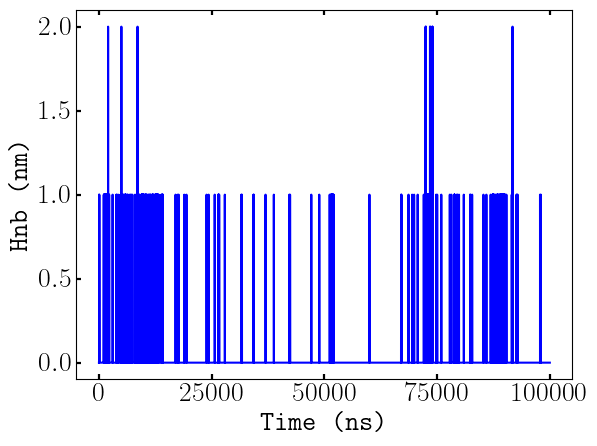

In [38]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
hbs = HBA(universe=E6_sildenafil_complex,
    update_selections=False
    )
hbs.donors_sel = hbs.guess_donors("protein")
hbs.hydrogens_sel = hbs.guess_hydrogens("protein")
hbs.acceptors_sel = hbs.guess_acceptors("resname VIA")
# Run the analysis

hbs.run(verbose=True)
ligand_indices = E6_sildenafil_complex.select_atoms(hbs.acceptors_sel).indices    
filtered_hbonds = []
for hb in hbs.results.hbonds:
    frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
    if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
        filtered_hbonds.append(hb)
    if donor_idx not in ligand_indices and acceptor_idx in ligand_indices:
        filtered_hbonds.append(hb)
hbs.results.hbonds = np.array(filtered_hbonds)


nhb_df = None
times = hbs.times
nhb = hbs.count_by_time()
E6_sildenafil_df['Nhb'] = nhb
nhb_df = pd.DataFrame({'Time': times, 'Nhb': nhb})
plt.plot(nhb_df['Time'], nhb_df['Nhb'], label='Nhb', color='blue')
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.show()

### Plot everything

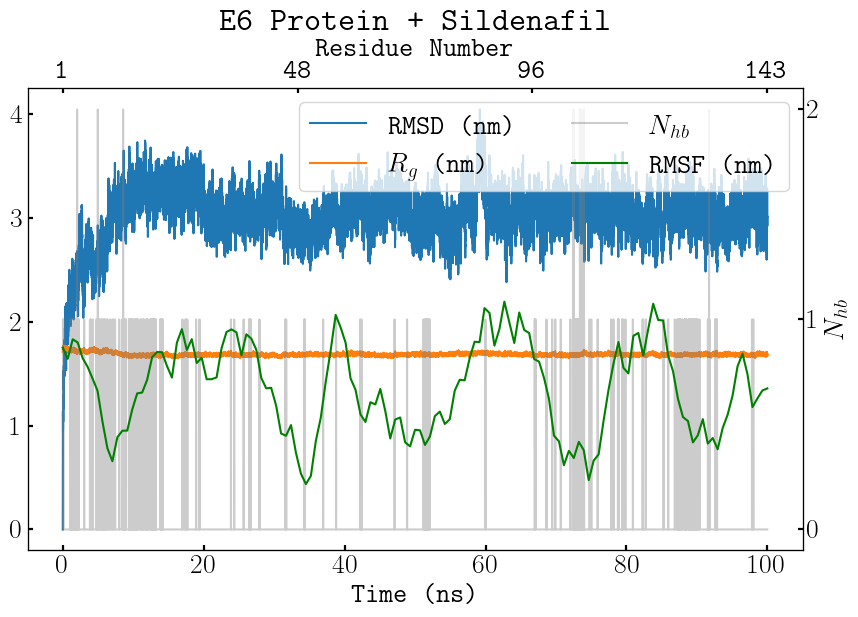

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSD and Rg on the left y-axis
ax1.set_xlabel('Time (ns)')
#ax1.set_ylabel('RMSD / Rg (nm)', color='tab:blue')
ax1.plot(E6_sildenafil_df.index/1000, E6_sildenafil_df['RMSD'], color='tab:blue', label='RMSD (nm)')
ax1.plot(E6_sildenafil_df.index/1000, E6_sildenafil_df['Rg'], color='tab:orange', label=r'$R_g$ (nm)')
ax1.legend(loc='upper left')

# Create secondary y-axis for Nhb
ax2 = ax1.twinx()
ax2.set_yticks([0,1,2])
ax2.set_ylabel(r'$N_{hb}$')
ax2.plot(E6_sildenafil_df.index/1000, E6_sildenafil_df['Nhb'], color='gray', label=r'$N_{hb}$', alpha=0.4)
ax2.legend(loc='upper right')

ax_top = ax1.twiny()
    
ax_top.plot(resids, rmsf/10,label="RMSF (nm)", color='green')
ax_top.set_xlabel('Residue Number')
ticks = np.linspace(resids[0], resids[-1], 4)
ax_top.set_xticks(ticks)
ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
ax_top.legend(loc='lower right')
plt.title('E6 Protein + Sildenafil')
# Remove individual legends to create a single legend
ax1.get_legend().remove()
ax2.get_legend().remove()
ax_top.get_legend().remove()

# Collect handles and labels from all axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax_top.get_legend_handles_labels()
all_handles = handles1 + handles2 + handles3
all_labels = labels1 + labels2 + labels3

# Create a unified legend
plt.legend(all_handles, all_labels, loc='upper right', ncol=2)
leg = plt.gca().get_legend()
leg.get_frame().set_alpha(0.8)
plt.savefig('E6_sildenafil_analysis.svg', dpi=300, bbox_inches='tight')
plt.show()